In [1]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
from pyemd import emd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

def combine(state, goal):
    if state is None:
        return None
    return torch.cat((state, goal), 1)

In [14]:
class miniDQN(nn.Module):

    def __init__(self, hidden):
        super(miniDQN, self).__init__()
        self.W1 = nn.Linear(8, hidden) # state + goal
        self.W2 = nn.Linear(hidden, 4)
        nn.init.xavier_uniform_(self.W1.weight)
        nn.init.xavier_uniform_(self.W2.weight)

    def forward(self, x):
        x = F.relu(self.W1(x))
        return self.W2(x)

#For now, embedding on states (not state-action pairs) because we're lazy
class embeddingNN(nn.Module):

    def __init__(self, hidden, output):
        super(embeddingNN, self).__init__()
        self.W1 = nn.Linear(8, hidden) # state + goal
        self.W2 = nn.Linear(hidden, output)
        nn.init.xavier_uniform_(self.W1.weight)
        nn.init.xavier_uniform_(self.W2.weight)

    def forward(self, x):
        x = F.relu(self.W1(x))
        return self.W2(x)

In [15]:
num_row = 10
num_col = 10

action_direction = [(0,1), (0,-1), (1,0), (-1,0)]

reds = [(3,0)]
blues = [(0,3)]
walls = []

start_state = np.asarray([0,0,0,0])
end_state = np.asarray([4,4,1,1])
torch_end = torch.from_numpy(end_state).float().unsqueeze(0)

RANDOM_ACTION_EPSILON = 0.1

def is_done(s):
    return np.array_equal(s, end_state)

def step(s, a):
    row, col, blue, red = tuple(s)
    if np.random.random() < RANDOM_ACTION_EPSILON:
        a = np.random.choice(4)
    a_row, a_col = action_direction[a]

    row = row + a_row
    col = col + a_col

    if row < 0 or row >= num_row or col < 0 or col >= num_col or (row, col) in walls:
        return s

    blue = blue or (row, col) in blues
    red = red or (row, col) in reds

    return np.asarray((row, col, blue, red))

def get_reward(s, a, s_prime):
    if is_done(s):
        return 0.0
    return -1.0

def L1(s1, s2):
    return 1.0 * np.sum(np.abs(np.asarray(s1) - np.asarray(s2)))

In [16]:
#Very adhoc, requires reversible dynamics
distance_cache = {}

def distance(a, b):
    global distance_cache
    ta = tuple(a)
    tb = tuple(b)
    if (ta,tb) in distance_cache:
        return distance_cache[(ta,tb)]
    
    row_a, col_a, blue_a, red_a = ta
    row_b, col_b, blue_b, red_b = tb
    
    blue_match = blue_a == blue_b
    red_match = red_a == red_b
    
    if red_match and not blue_match:
        dist = min([L1((row_a,col_a),blue) + L1(blue, (row_b, col_b)) for blue in blues])
    elif not red_match and blue_match:
        dist = min([L1((row_a,col_a),red) + L1(red, (row_b, col_b)) for red in reds])
    elif not red_match and not blue_match:
        x = min([L1((row_a,col_a),red) + L1(red, blue) + L1(blue, (row_b, col_b)) for red, blue in zip(reds, blues)])
        y = min([L1((row_a,col_a),blue) + L1(blue, red) + L1(red, (row_b, col_b)) for red, blue in zip(reds, blues)])
        dist = min(x,y)
    else:
        dist = L1(ta, tb)
    distance_cache[(ta,tb)] = dist
    return dist

In [52]:
BATCH_SIZE = 64
GAMMA = 0.9999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 6000
TARGET_UPDATE = 50
HIDDEN_LAYER_SIZE = 15
EMBEDDING_SIZE = 10
EMBEDDING_LAMBDA = 0.001
EPISODE_LENGTH = 30
LEARNING_RATE = 0.0004

DIVERSE_EXPERT = True

num_episodes = 60000
random.seed(10)
distance_cache = {}

policy_net = miniDQN(HIDDEN_LAYER_SIZE).to(device)
target_net = miniDQN(HIDDEN_LAYER_SIZE).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr = LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)
memory = ReplayMemory(40000)
expert_memory = ReplayMemory(40000)

In [53]:
embedding_net = embeddingNN(HIDDEN_LAYER_SIZE, EMBEDDING_SIZE).to(device)

embedding_optimizer = optim.Adam(embedding_net.parameters(), lr = LEARNING_RATE)

In [54]:
steps_done = 0

#Epsilon greedy actions
def select_action(state, goal, test = False):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if test or sample > eps_threshold:
        with torch.no_grad():
            x = torch.cat((state, goal), 1)
            return policy_net(x).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(4)]], device=device, dtype=torch.long)

#Max entropy action
def select_action_entropy(state, goal, alpha):
    x = torch.cat((state, goal), 1)
    potential = (alpha * policy_net(x).detach()).exp().squeeze()
    dist = (potential / potential.sum()).numpy()
    return torch.tensor([[np.random.choice(4, p = dist)]], device=device, dtype=torch.long)
    

def select_expert_action(state, goal):
    row, col, blue, red = tuple(state)
    action_scores = np.zeros(4)
    for a in range(4):
        #Assumes determinism!!!
        #TODO FIX THIS
        next_state = step(state, a)
        action_scores[a] = distance(next_state, goal)
    action = np.random.choice(np.flatnonzero(action_scores == action_scores.min()))
    return torch.tensor([[action]], device=device, dtype=torch.long)    

def sample_expert_trajectory():
    state = start_state
    next_state = None

    trajectory = []
    
    for t in range(EPISODE_LENGTH):
        action = select_expert_action(state, end_state)
        
        torch_state = torch.from_numpy(state).float().unsqueeze(0)
        next_state = step(state, action.item())
        torch_next_state = torch.from_numpy(next_state).float().unsqueeze(0)
        reward = get_reward(state, action.item(), next_state)
        done = is_done(state)
        reward = torch.tensor([reward], device=device)
        if done:
            torch_next_state = None

        trajectory.append((torch_state, action, torch_next_state, reward))
        if done:
            break
        state = next_state
    return trajectory

In [55]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    #randomly learn over expert trajectories or rollout buffer
    transitions = memory.sample(BATCH_SIZE) if np.random.random() > 0.5 else expert_memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,batch.next_state)),
                                  device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    #DDQN
    policy_action_indices = policy_net(non_final_next_states).max(1)[1].detach()
    target_actions = target_net(non_final_next_states).detach()
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_actions.gather(1, policy_action_indices.unsqueeze(1)).squeeze()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    return loss.item()

In [56]:
def sample_buffer():
    transitions = memory.sample(BATCH_SIZE) if np.random.random() > 0.5 else expert_memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,batch.next_state)),
                                  device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    state_embeddings = embedding_net(state_batch)
    next_state_embeddings = torch.zeros((BATCH_SIZE, EMBEDDING_SIZE), device=device)
    next_state_embeddings[non_final_mask,:] = embedding_net(non_final_next_states)
        
    return (state_embeddings, reward_batch, next_state_embeddings)


def optimize_bisim():
    if len(memory) < BATCH_SIZE:
        return
    
    sample_1 = sample_buffer()
    sample_2 = sample_buffer()

    distance = torch.norm(sample_1[0] - sample_2[0], dim = 1)
    reward_distance = torch.abs(sample_1[1] - sample_2[1])
    next_distance = torch.norm(sample_1[2] - sample_2[2], dim = 1)
    
    TD_error = reward_distance + GAMMA * next_distance
    
    loss = F.smooth_l1_loss(distance, TD_error.detach()) #Detaching because the loss function complains
    
    loss += EMBEDDING_LAMBDA * torch.mean(torch.norm(sample_1[0], dim = 1) + torch.norm(sample_2[0], dim = 1))
    
    # Optimize the model
    embedding_optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    embedding_optimizer.step()
    return loss.item()

In [57]:
losses = [0]
bisim_losses = [0]
expert_trajectory = sample_expert_trajectory()
#pre-populate the replay buffers
for i in range(1000):
    if DIVERSE_EXPERT:
        expert_trajectory = sample_expert_trajectory()
    for torch_state, action, torch_next_state, reward in expert_trajectory:
        memory.push(combine(torch_state, torch_end), action, combine(torch_next_state, torch_end), reward)
        expert_memory.push(combine(torch_state, torch_end), action, combine(torch_next_state, torch_end), reward)

In [58]:
for i_episode in range(num_episodes):
    state = start_state
    next_state = None
    final = i_episode == num_episodes - 1
    trajectory = []
    
    if i_episode % 1000 == 0:
        scheduler.step()
    
    for t in range(EPISODE_LENGTH):
        torch_state = torch.from_numpy(state).float().unsqueeze(0)

        action = select_action(torch_state, torch_end, final)
            
        next_state = step(state, action.item())
        torch_next_state = torch.from_numpy(next_state).float().unsqueeze(0)
        reward = get_reward(state, action.item(), next_state)
        done = is_done(state)
        reward = torch.tensor([reward], device=device)

        if done:
            torch_next_state = None

        trajectory.append((torch_state, action, torch_next_state, reward))

        loss = optimize_model()
        bisim_loss = optimize_bisim()
        losses.append(loss if loss is not None else 0)
        bisim_losses.append(bisim_loss if bisim_loss is not None else 0)
        if final:
            print(state)
        if done:
            break
        state = next_state

    if i_episode % 1000 == 0:
        print(i_episode)
        print(np.mean(np.asarray(losses)))
        print(np.mean(np.asarray(bisim_losses)))
        losses = []
        bisim_losses = []

    #HER updates with goal as real goal OR last state in trajectory
    for torch_state, action, torch_next_state, reward in trajectory:
        memory.push(combine(torch_state, torch_end), action, combine(torch_next_state, torch_end), reward)
        if not is_done(state):
            torch_local_goal = torch.from_numpy(state).float().unsqueeze(0)
            local_reward = torch.equal(torch_next_state, torch_local_goal)
            new_reward = torch.add(reward, local_reward)
            memory.push(combine(torch_state, torch_local_goal), action, combine(torch_next_state, torch_local_goal), new_reward)
                    
                          
    # Update the target network
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
        
print('Complete')

0
0.2615947872400284
0.5578185118013813
1000
0.08933876645849087
57.47480605968734
2000
0.18191488969657651
129.79731238571026
3000
0.2937623049701043
491.3208651889649
4000
0.3873383050495345
911.4914302556252
5000
0.2005500910045457
1038.360388114192
6000
0.17440970320994237
830.5746664755796
7000
0.16264415523015
906.5390971819259
8000
0.16633447771564355
1137.1129436145682
9000
0.15550179547672788
1024.2768348224536
10000
0.1354831588063812
969.0483339078366
11000
0.14101893969252768
977.6296507382908
12000
0.16665387081443597
1028.316779566356
13000
0.1413168122206192
933.387665696979
14000
0.11314426146261675
732.8901267865199
15000
0.11485317699837816
347.19563427633017
16000
0.10514253552706651
155.72595189866564
17000
0.09233168642914083
54.97891737890849
18000
0.0930581665845988
14.180560723436336
19000
0.09887738548700768
6.2781991647965265
20000
0.09687340482579285
1.9303941171291477
21000
0.09328276256764456
0.8472878856411871
22000
0.09091218232127768
0.3362181408482873
2

In [84]:
def predicted_embedding(state, goal):
    torch_state = torch.from_numpy(state).float().unsqueeze(0)
    torch_goal = torch.from_numpy(goal).float().unsqueeze(0)
    x = torch.cat((torch_state, torch_goal), 1)
    return embedding_net(x).cpu().detach().numpy()

print(predicted_embedding(np.asarray([2,1,0,0]), end_state))
print(predicted_embedding(np.asarray([1,2,0,0]), end_state))
print(predicted_embedding(np.asarray([1,2,1,0]), end_state))
print(predicted_embedding(np.asarray([1,2,1,1]), end_state))
print()
print(predicted_embedding(np.asarray([3,4,1,1]), end_state))
print(predicted_embedding(np.asarray([4,3,1,1]), end_state))

[[-1.6599503  -0.35394287 -2.0398026   0.35004044 -0.23666382  0.2878189
  -0.8253517   0.04642868 -1.7412071  -0.90213776]]
[[-1.4036179  -0.13687134 -2.1569595   0.44662857  0.15756226  0.8244095
  -0.76202774 -0.10896683 -2.196926   -0.9255905 ]]
[[-1.2060318   0.40481567 -1.4898453   1.5436745   0.4743042   1.2394485
  -0.50268936  0.79343796 -1.038723   -0.83408356]]
[[-0.15847015  0.11639404 -0.9845047   2.082615    0.6481018   0.52143097
  -0.5998268  -0.27528763 -1.3954124  -0.05225372]]

[[-0.35346222  0.54348755  0.56816864  0.37005997  0.52941895  1.260292
  -0.60821915 -0.7946663  -1.1621971  -0.72304535]]
[[-0.6096878   0.3265381   0.68535614  0.27356339  0.1352539   0.7238846
  -0.6716347  -0.6392708  -0.7066612  -0.6996231 ]]


In [61]:
def predicted_distance(state, goal):
    torch_state = torch.from_numpy(state).float().unsqueeze(0)
    torch_goal = torch.from_numpy(goal).float().unsqueeze(0)
    x = torch.cat((torch_state, torch_goal), 1)
    return -1 * policy_net(x).max(1)[0].view(1, 1).item()

def predicted_measure_ball(state, goal, n = 500):
    measure = {}
    torch_state = torch.from_numpy(state).float().unsqueeze(0)
    torch_goal = torch.from_numpy(goal).float().unsqueeze(0)
    x = torch.cat((torch_state, torch_goal), 1)
    for i in range(n):
        action = select_action_entropy(torch_state, torch_goal, alpha = 4.0)
        next_state = step(state, action.item())
        key = tuple(next_state)
        measure[key] = measure.get(key, 0) + 1.0/n
    return measure

def wasserstein(a, b, goal):
    if tuple(a) == tuple(b):
        return 0
    m_a = predicted_measure_ball(a, goal)
    m_b = predicted_measure_ball(b, goal)
    states = list(set(m_a.keys()) | set(m_b.keys()))
    
    m_a = [m_a.get(s, 0.0) for s in states]
    m_b = [m_b.get(s, 0.0) for s in states]
    dist = [[distance(np.asarray(s1),np.asarray(s2)) for s1 in states] for s2 in states]
    return emd(np.asarray(m_a), np.asarray(m_b), np.asarray(dist))


In [62]:
values = np.zeros((num_row, num_col, 2, 2))
for index in np.ndindex(num_row, num_col, 2, 2):
    values[index] = predicted_distance(np.asarray(index), end_state)
print(np.round(values[:,:,0,0], 2))
print(np.round(values[:,:,1,0], 2))
print(np.round(values[:,:,0,1], 2))
print(np.round(values[:,:,1,1], 2))

[[14.4  13.38 12.47 12.66 12.66 14.38 15.79 17.2  18.61 20.02]
 [13.95 14.41 13.53 12.97 12.41 13.86 15.18 16.51 17.84 19.16]
 [12.85 14.45 14.34 14.43 14.22 15.63 16.95 18.28 19.61 20.94]
 [11.81 13.67 14.3  14.56 14.75 16.71 18.67 20.05 21.38 22.71]
 [13.46 14.57 15.76 16.28 16.49 18.54 20.23 21.91 23.6  25.03]
 [14.21 15.32 16.53 18.05 19.21 21.95 23.64 25.32 27.01 28.69]
 [14.97 16.08 17.3  18.82 21.76 25.51 27.04 28.73 30.41 32.1 ]
 [15.73 16.84 18.06 19.59 23.06 28.89 30.86 32.13 33.82 35.5 ]
 [16.48 17.6  18.83 20.36 24.37 30.2  34.41 36.22 37.22 38.91]
 [17.24 18.35 19.6  21.12 25.68 31.51 36.77 39.76 41.58 42.35]]
[[ 8.17  9.36 10.36 11.35 12.34 13.33 15.07 17.78 20.49 21.41]
 [ 7.16  8.29  9.3  10.3  11.31 12.31 14.22 16.92 19.63 22.34]
 [ 6.15  7.22  8.22  9.23 10.24 11.25 13.36 16.07 18.77 21.48]
 [ 5.14  6.14  7.15  8.16  9.17 10.17 12.5  15.21 17.92 20.62]
 [ 6.94  7.54  8.27  9.    9.73 10.46 12.71 15.14 17.57 20.  ]
 [ 7.7   8.53  9.55 10.57 11.59 12.66 15.09 17.52 19.9

No handles with labels found to put in legend.


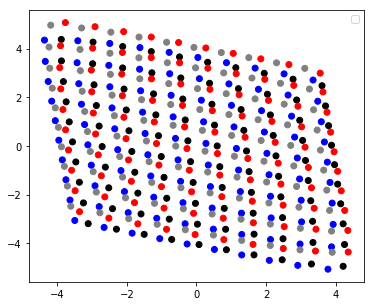

In [82]:
from sklearn.manifold import MDS

values = []
colors = []
color_dict = {(0,0) : 'black', (1,0): 'blue', (0,1): 'red', (1,1): 'gray'}
for index in np.ndindex(num_row, num_col, 2, 2):
    values.append(predicted_embedding(np.asarray(index), end_state))
    colors.append(color_dict[index[2:]])
values = np.vstack(values)

X = MDS().fit_transform(values)

plt.figure(figsize=(6, 5))
plt.scatter(X[:,0], X[:,1], c=colors)
plt.legend()
plt.show()

